In [318]:
import numpy as np
import json
import matplotlib.pyplot as plt 
from scipy.spatial import Delaunay 
import skimage as sk
import scipy as sci
import scipy.interpolate


In [240]:
with open('../../Morphing/Photos/fullBodyV3.json') as jsonFile:
    keyPoints = json.load(jsonFile)

In [241]:
im1Points = np.array(keyPoints['im1Points'])
im2Points = np.array(keyPoints['im2Points'])
print(im1Points[1], im2Points[1])

[565 338] [537 433]


In [242]:
np.average([im2Points[0], im2Points[0]], axis=0)

array([212., 441.])

In [297]:
averagePoints = [np.average(a, weights=[0.9, 0.1], axis=0) for a in zip(im1Points, im2Points)]
averagePoints = np.array(averagePoints)
print(averagePoints.shape)

(53, 2)


In [298]:
triAverage = Delaunay(averagePoints) 
# triIm1 = Delaunay(im1Points)
# triIm2 = Delaunay(im2Points)

In [299]:
#Average tri on img2 face
# fig = plt.figure()
# fig, ax = plt.subplots()
# img = plt.imread('../../Morphing/Photos/thomasRescaled.jpg')
# ax.imshow(img)

# plt.triplot(im2Points[:,0], im2Points[:,1], triIm2.simplices)
# plt.plot(im2Points[:,0], im2Points[:,1], 'o')
# ax.set_aspect('equal', adjustable='box')

<Figure size 640x480 with 0 Axes>

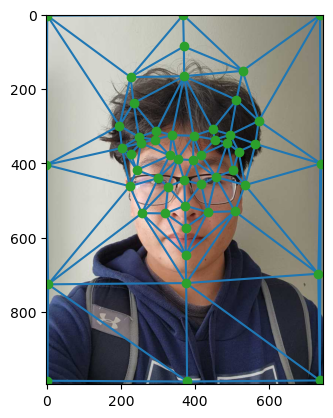

In [300]:
#Average tri on img2 face
fig = plt.figure()
fig, ax = plt.subplots()
thomasImg = plt.imread('../../Morphing/Photos/thomasRescaled.jpg')
diddyImg = plt.imread('../../Morphing/Photos/diddyRescaled.jpg')
ax.imshow(thomasImg)

plt.triplot(averagePoints[:,0], averagePoints[:,1], triAverage.simplices)
plt.plot(averagePoints[:,0], averagePoints[:,1], 'o')
ax.set_aspect('equal', adjustable='box')


<Figure size 640x480 with 0 Axes>

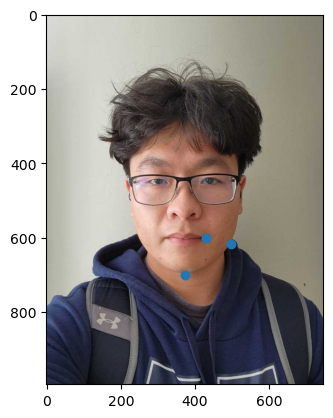

In [301]:
#Select points
fig = plt.figure()
fig, ax = plt.subplots()
img = plt.imread('../../Morphing/Photos/thomasRescaled.jpg')
ax.imshow(img)

plt.plot([im2Points[6,0], im2Points[21,0], im2Points[19,0]], [im2Points[6,1], im2Points[21,1], im2Points[19,1]], 'o')
ax.set_aspect('equal', adjustable='box')

<Figure size 640x480 with 0 Axes>

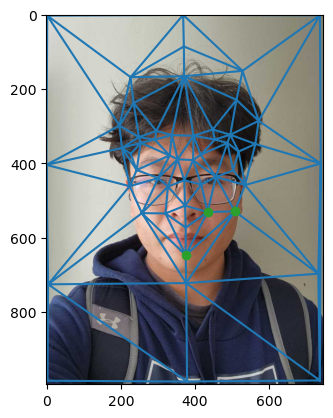

In [302]:
#Select points
fig = plt.figure()
fig, ax = plt.subplots()
img = plt.imread('../../Morphing/Photos/thomasRescaled.jpg')
ax.imshow(img)

plt.triplot(averagePoints[:,0], averagePoints[:,1], triAverage.simplices)
plt.plot([averagePoints[6,0], averagePoints[21,0], averagePoints[19,0]], [averagePoints[6,1], averagePoints[21,1], averagePoints[19,1]], 'o')
ax.set_aspect('equal', adjustable='box')

In [303]:
[im2Points[20,0], im2Points[5,0], im2Points[19,0]], [im2Points[20,1], im2Points[5,1], im2Points[19,1]]

([255, 322, 372], [613, 602, 699])

In [304]:
# print(triIm1.simplices[3])
print(triAverage.simplices[3])

[31 33 42]


In [305]:
#Triangle Vert is a 3x2 array
def imgToTriangle(triangleVert, img):
    mask = sk.draw.polygon2mask(img.shape[0:3], triangleVert)
    # print(mask.shape)
    return img * mask
   #return np.stack(img[:,:,0] * mask, img[:,:,1] * mask, img[:,:,2] * mask, axis=2)

In [306]:
#Inverse transform from t1 to t2
def affineTrans(triIndex, t1Points, t1Simplicies, t2Points):
    t1 = [t1Points[i] for i in t1Simplicies[triIndex]]
    t2 = [t2Points[i] for i in t1Simplicies[triIndex]]
    # print(t1)
    # print(t2)
    t1Vec = np.array([t1[0] - t1[1],  t1[0] - t1[2]]).T
    t2Vec = np.array([t2[0] - t2[1],  t2[0] - t2[2]]).T
    # print(t1Vec)
    # print(t2Vec)
    t1VecToRight = np.eye(3)
    t1VecToRight[0:2, 0:2] = t1Vec
    t1VecToRight[0:2, 2] = t1[0]
    t1VecToRight = np.linalg.inv(t1VecToRight)

    rightToT2 = np.eye(3)
    rightToT2[0:2, 0:2] = t2Vec
    rightToT2[0:2, 2] = t2[0]

    return rightToT2 @ t1VecToRight
    

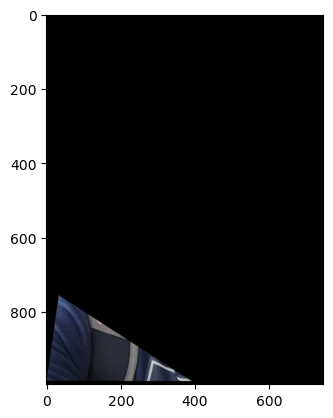

In [307]:
#Need to reverse x and y.
maskedIm2 = imgToTriangle([[im2Points[i][1],im2Points[i][0]] for i in triAverage.simplices[3]], img)
plt.imshow(maskedIm2)

In [308]:
inverseMap = affineTrans(3, averagePoints, triAverage.simplices, im2Points)

In [309]:
warmpedIm2 = sk.transform.warp(maskedIm2, inverseMap)
warmpedIm2.shape

(995, 746, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


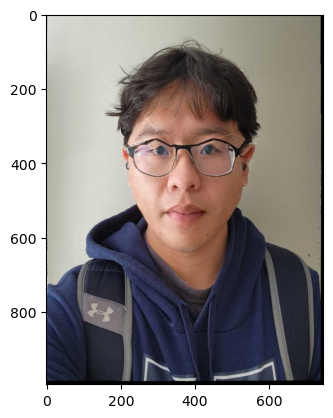

In [310]:
def warpImg(im1Points, im1Tri, im2Points, img):
    warpedIm2 = np.zeros_like(img).astype(np.float64)
    for i in range(0, len(im1Tri.simplices)):
        maskedIm2 = imgToTriangle([[im2Points[i][1],im2Points[i][0]] for i in im1Tri.simplices[i]], img)
        inverseMap = affineTrans(i, im1Points, triAverage.simplices, im2Points)
        warpedIm2 += sk.transform.warp(maskedIm2, inverseMap)
    return warpedIm2
thomasAvg = warpImg(averagePoints, triAverage, im2Points, thomasImg)
plt.imshow(thomasAvg)

In [327]:

scipy.interpolate.griddata()

46227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


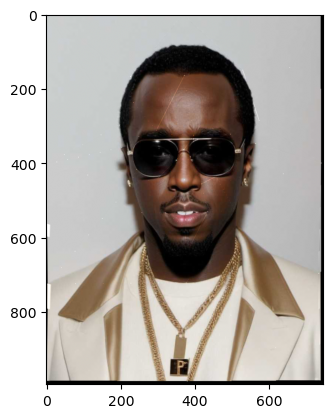

In [311]:
diddyAvg = warpImg(averagePoints, triAverage, im1Points, diddyImg)
plt.imshow(diddyAvg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


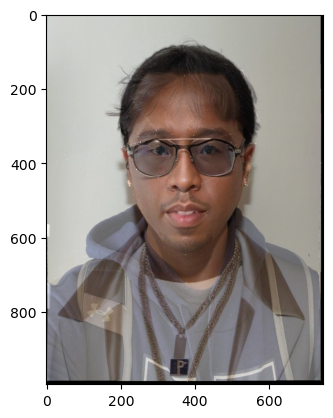

In [312]:
thomasDiddyMerge = ((thomasAvg + diddyAvg)/2)
# thomasDiddyMerge = thomasDiddyMerge/np.max(thomasDiddyMerge)
plt.imshow(thomasDiddyMerge)

In [ ]:
sci.interpolate.griddata(warpedIm2[:,:,0])

In [25]:
im2Points[20]

array([255, 613])

In [17]:
#using 0 index vertice as right angle
triangleVector1 = np.array([im2Points[triIm2.simplices[0][0]] - im2Points[triIm2.simplices[0][1]],  im2Points[triIm2.simplices[0][0]] - im2Points[triIm2.simplices[0][2]]]).T
print(triangleVector1)

[[   1  190]
 [-107 -118]]


In [13]:
triangleVector1 = np.array([im2Points[triIm2.simplices[0][0]] - im2Points[triIm2.simplices[0][1]],  im2Points[triIm2.simplices[0][0]] - im2Points[triIm2.simplices[0][2]]]).T
t2_to_right_angle = np.eye(3)
t2_to_right_angle[0:2, 0:2] = triangleVector1
t2_to_right_angle[0:2, 2] = im2Points[triIm2.simplices[0][0]]
t2_to_right_angle

array([[   1.,  190.,  367.],
       [-107., -118.,  176.],
       [   0.,    0.,    1.]])

In [23]:
inverseT2_to_right_angle = np.linalg.inv(t2_to_right_angle)
print(inverseT2_to_right_angle)

[[-5.83811597e-03 -9.40035622e-03  3.79705126e+00]
 [ 5.29388482e-03  4.94755591e-05 -1.95156343e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [22]:
#using 0 index vertice as right angle
triangleVectorAverage = np.array([averagePoints[triAverage.simplices[0][0]] - averagePoints[triAverage.simplices[0][1]],  averagePoints[triAverage.simplices[0][0]] - averagePoints[triAverage.simplices[0][2]]]).T
tright_angle_to_average = np.eye(3)
tright_angle_to_average[0:2, 0:2] = triangleVectorAverage
tright_angle_to_average[0:2, 2] = averagePoints[triAverage.simplices[0][0]]
print(tright_angle_to_average)

[[   1.  190.  367.]
 [-107. -118.  176.]
 [   0.    0.    1.]]


In [21]:
t2_to_average = tright_angle_to_average @ inverseT2_to_right_angle
print(t2_to_average)

[[1.00000000e+00 1.04354459e-18 0.00000000e+00]
 [6.93889390e-18 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
